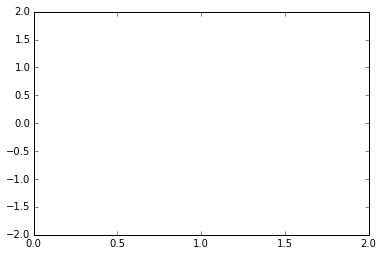

In [3]:
"""
Matplotlib Animation Example

author: Jake Vanderplas
email: vanderplas@astro.washington.edu
website: http://jakevdp.github.com
license: BSD
Please feel free to use and modify this, but keep the above information. Thanks!
"""

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
%matplotlib inline
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
#anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

plt.show()

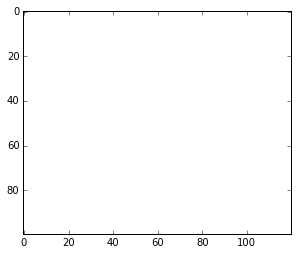

In [6]:
#!/usr/bin/env python
"""
An animated image
"""
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

fig = plt.figure()

def f(x, y):
    return np.sin(x) + np.cos(y)

x = np.linspace(0, 2 * np.pi, 120)
y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)
# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(60):
    x += np.pi / 15.
    y += np.pi / 20.
    im = plt.imshow(f(x, y))
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
    repeat_delay=1000)

#ani.save('dynamic_images.mp4')


#plt.show()

In [11]:
import csv
import numpy as np
import urllib2
import StringIO
import pickle
import scitools.easyviz as scit
from matplotlib.transforms import Bbox, TransformedBbox, \
     blended_transform_factory
from mpl_toolkits.axes_grid1.inset_locator import BboxPatch, BboxConnector,\
     BboxConnectorPatch
import matplotlib.pyplot as plt
 
# Open file
response = urllib2.urlopen('http://glider.ceotr.ca/data/live/sci_water_temp_live.csv')
data = response.read()
data = StringIO.StringIO(data)
 
# Read file
r = csv.DictReader(data)
 
# Initialize empty variables
date, lat, lon, depth, temp = [],[],[],[],[]
 
# Loop to parse data into our variables
for row in r:
    date.append(float(row['unixtime']))
    lat.append(float(row['lat']))
    lon.append(float(row['lon']))
    depth.append(float(row['depth']))
    temp.append(float(row['sci_water_temp']))
 
# Estimate "distance along transect *******************************************
 
# First, design a function to estimate great-circle distance
def distance(origin, destination):
    #Source: http://www.platoscave.net/blog/2009/oct/5/calculate-distance-latitude-longitude-python/
    import math
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km
 
    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c
 
    return d
 
# Compute distance along transect
dist = np.zeros((np.size(lon)))
for i in range(2,np.size(lon)):
    dist[i] = dist[i-1] + distance([lat[i-1], lon[i-1]], [lat[i], lon[i]])
 
# Estimate bathymetry **********************************************************
# Load bathymetry file created here: http://oceanpython.org/2013/03/21/bathymetry-topography-srtm30/
T = pickle.load(open('/home/diego/PythonTutorials/SRTM30/topo.p','rb'))
 
# Compute bathymetry
bathy = np.zeros((np.size(lon)))
for i in range(np.size(lon)):
    cost_func = ((T['lons']-lon[i])**2) + ((T['lats']-lat[i])**2)
    xmin, ymin = np.unravel_index(cost_func.argmin(), cost_func.shape)
    bathy[i] = -T['topo'][xmin, ymin]
 
# Fuctions for zoom effect ****************************************************
# Source: http://matplotlib.org/dev/users/annotations_guide.html#zoom-effect-between-axes
def connect_bbox(bbox1, bbox2,
                 loc1a, loc2a, loc1b, loc2b,
                 prop_lines, prop_patches=None):
    if prop_patches is None:
        prop_patches = prop_lines.copy()
        prop_patches["alpha"] = prop_patches.get("alpha", 1)*0.2
 
    c1 = BboxConnector(bbox1, bbox2, loc1=loc1a, loc2=loc2a, **prop_lines)
    c1.set_clip_on(False)
    c2 = BboxConnector(bbox1, bbox2, loc1=loc1b, loc2=loc2b, **prop_lines)
    c2.set_clip_on(False)
 
    bbox_patch1 = BboxPatch(bbox1, **prop_patches)
    bbox_patch2 = BboxPatch(bbox2, **prop_patches)
 
    p = BboxConnectorPatch(bbox1, bbox2,
                           #loc1a=3, loc2a=2, loc1b=4, loc2b=1,
                           loc1a=loc1a, loc2a=loc2a, loc1b=loc1b, loc2b=loc2b,
                           **prop_patches)
    p.set_clip_on(False)
 
    return c1, c2, bbox_patch1, bbox_patch2, p
 
def zoom_effect(ax1, ax2, xmin, xmax, **kwargs):
    """
    ax1 : the main axes
    ax1 : the zoomed axes
    (xmin,xmax) : the limits of the colored area in both plot axes.
 
    connect ax1 & ax2. The x-range of (xmin, xmax) in both axes will
    be marked.  The keywords parameters will be used ti create
    patches.
 
    Source: http://matplotlib.org/dev/users/annotations_guide.html#zoom-effect-between-axes
 
    """
 
    trans1 = blended_transform_factory(ax1.transData, ax1.transAxes)
    trans2 = blended_transform_factory(ax2.transData, ax2.transAxes)
 
    bbox = Bbox.from_extents(xmin, 0, xmax, 1)
 
    mybbox1 = TransformedBbox(bbox, trans1)
    mybbox2 = TransformedBbox(bbox, trans2)
 
    prop_patches=kwargs.copy()
    prop_patches["ec"]="r"
    prop_patches["alpha"]=None
    prop_patches["facecolor"]='none'
    prop_patches["linewidth"]=2
 
    c1, c2, bbox_patch1, bbox_patch2, p = \
        connect_bbox(mybbox1, mybbox2,
                     loc1a=3, loc2a=2, loc1b=4, loc2b=1,
                     prop_lines=kwargs, prop_patches=prop_patches)
 
    ax1.add_patch(bbox_patch1)
    ax2.add_patch(bbox_patch2)
    ax2.add_patch(c1)
    ax2.add_patch(c2)
    ax2.add_patch(p)
 
    return c1, c2, bbox_patch1, bbox_patch2, p
 
# Make plots
nframes = 20
overlap = 0.95
window = np.floor(max(dist)-min(dist)) / (nframes - (nframes*overlap) + overlap)
 
xmin = 0
xmax = xmin + window
fig1 = plt.figure()
for i in range(0,nframes):
    ax1 = plt.subplot(211)
    plt.fill_between(dist,bathy,1000,color='k')
    plt.scatter(dist,depth,s=15,c=temp,marker='o', edgecolor='none')
    plt.ylim((-0.5,max(depth)+5))
    ax1.set_ylim(ax1.get_ylim()[::-1])
    cbar = plt.colorbar(orientation='vertical', extend='both')
    cbar.ax.set_ylabel('Temperature ($^\circ$C)')
    plt.title('OTN Glider transect')
    plt.ylabel('Depth (m)')
    ax1.set_xlim(min(dist),max(dist))
 
    ax2 = plt.subplot(212)
    plt.fill_between(dist,bathy,1000,color='k')
    plt.scatter(dist,depth,s=15,c=temp,marker='o', edgecolor='none')
    plt.ylim((-0.5,max(depth)+5))
    ax2.set_ylim(ax2.get_ylim()[::-1])
    plt.ylabel('Depth (m)')
    plt.xlabel('Distance along transect (km)')
    ax2.set_xlim(xmin,xmax)
    zoom_effect(ax1, ax2,xmin,xmax)
 
    # Save figure (without 'white' borders)
    if i < 10:
        plt.savefig('glider_0'+str(i)+'.png', bbox_inches='tight')
    else:
        plt.savefig('glider_'+str(i)+'.png', bbox_inches='tight')
 
    plt.close()
 
    xmin = xmax - np.floor(window*overlap)
    xmax = xmin + window
 
# make animated gif
#scit.movie('glider_*.png',encoder='convert',output_file='glider_movi

IOError: zipimport: can not open file /noc/users/am8e13/anaconda/lib/python2.7/site-packages/setuptools-14.3-py2.7.egg